# Twitter Data Extraction 

Module Code: **CS3PP19**

Assignment Report Title: **Twitter Data Extraction**

Student Numbers: **28010336, 28012606, 28006461**

Date Completed: **/11/2021** 

Actual hours spent for the assignment: **11 hours**

Assignment evaluation (3 key points):  
1. 
2. 
3.

# Introduction

In this data analysis task, we will analyse 3 selected Twitter accounts. Task 1; we data from twitter regarding, processing it into Pandas dataframes along with cleansing them down to crtical data only to reduce the size of our dataset. Task 2 merges all the data from the accounts and performs an explroatory data analysis (EDA) on the conjoined data in order to examine their characteristics. Specifically, we intend to analyse the following:

- Follower to following ratio (including the individual counts of each) plotted as a percentage bar of the ratio
- Activity share (status updates, retweets, favourites) represented as a piechart
- Most popular mentions
- Number of accounts that they are following
- Number of followers
- Number of original tweets that were posted
- Number of likes that each original tweet has
- Number of times that each original tweet have been retweeted
- Number of retweets that were posted by the user
- Number of tweets that the users have liked

Finally, task 3 creates a bi-directional graph of each account's area of influence - consituted of their followers and followings - in order to analyse the network of each account.

# Task 1 - Data Gathering and Pre-processing

Our 3 accounts' names are stored as a list for use throughout the notebook

In [1]:
accountNames = ["iJustine", "BarackObama", "LeoDiCaprio"]
accountIndices = {accountNames[0]: 0, accountNames[1]: 1, accountNames[2]: 2}
accountIDs = {} # Populated in data extraction

## API connection

Using Tweepy, we use our twitter developer account’s bearer token to authorise it’s usage and create an instance of Tweepy API v2 using *Client()*

https://docs.tweepy.org/en/stable/auth_tutorial.html

In [2]:
import tweepy

# The bearer token of our developer account
bearer = 'AAAAAAAAAAAAAAAAAAAAANiSVwEAAAAAaKxCBHUoe37A5VmVITnP%2FVQXtus%3DH71897v17xZqYvlc5Qh5uLHbpSyvaLGIElaBvBaPXGtI3tmMWP'

# Create and store a Tweepy client instance using our authroisation token. Also, set the rate_limit flag to true.
client = tweepy.Client(bearer_token=bearer, wait_on_rate_limit=True)

Using the Tweepy Client object, we extract basic information from Twitter, such as account ID's, metrics, and creation date.

https://docs.tweepy.org/en/stable/api.html#tweepy.API.get_user

In [3]:
# Create a list for usernames of the users to request data for
usernameList = accountNames[0]

# Populate list with the usernames in the required format
index = 0
for name in accountNames:
    if(index == 0):
        continue
        
    usernameList += ","
    usernameList += name

# Retrieve the user data
users = client.get_users(
    usernames="iJustine,BarackObama,LeoDiCaprio", 
    user_fields=['id', 'name', 'public_metrics', 'created_at']
).data

## Data extraction

In the data extraction stage, we collect all data we require from the Twitter API for our analysis purposes.

; for us, we define this as a set of API calls and selecting the raw data from which we will use - reducing the size our dataset(s).

In order to obtain the following list, we searched the api documentation of Tweepy (https://docs.tweepy.org/en/stable/api.html) and sought at methods which can acquire useful data of an account. These methods are:
- Friends - get_friends()
- Followers - get_followers()
- Posts - user_timeline()
- Retweets - get_retweets(), get_retweets_of_me()
- Likes - get_favourites()

**Should this only be in task 2's explanation, to not have duplication and because some of this data requires processing, thus now raw data?**

The list below shows all the raw data that we will be extracting from the accounts:
- Number of accounts that they are following. - Following Count
- Number of followers. - Follower count
- Number of original tweets that were posted. - Original tweet count
- Number of likes that each original tweet has. - original tweet like count
- Number of times that each original tweet have been retweeted. - original tweet retweet count
- Number of retweets that were posted by the user. - retweet count


- Number of tweets that the users have liked.


- Number of times that the accounts were mentioned.


In [4]:
import pandas as pd

# Set options regarding Pandas's display of dataframes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

# https://developer.twitter.com/en/docs/twitter-api/rate-limits

class RawUserData:
    
    # Maximum limits
    MAX_TWEETS = 300
    MAX_FOLLOWERS = 100
    MAX_FOLLOWING = 100
    
    # User information
    userID = None
    username = None # The username of the account this UserData represents
    dateJoined = None # The date the account was created
    
    # Metrics
    followingCount = None # The number of people this account follows
    followersCount = None # The number of people following this account
    tweetCount = None # The number of tweets this account has made
    likesCount = None # The number of likes the account has done
    retweetCount = None # The number of retweets the account has done
    mentionCount = None # The number of times this account has mentioned someone/something in a tweet
    
    # User activity
    tweets = [] # The tweets this account has made (original tweets)
    
    # Network
    followers = [] # The followers the account has
    following = [] # The friends the account has
    
    # RawData constructor
    def __init__(self, user): 
        self.userID = user.id
        self.name = user.name
        self.followingCount = user.public_metrics['following_count']
        self.followersCount = user.public_metrics['followers_count']
        self.tweetCount= user.public_metrics['tweet_count']
        self.likesCount = user.public_metrics['tweet_count']
        self.dateJoined = user.created_at.strftime('%d-%m-%Y')
        
        # Get tweets using pagination
        self.tweets = self.paginate(client.get_users_tweets, self.MAX_TWEETS)
                
        # Get followrs and followings using pagination
        self.followers = self.paginate(client.get_users_followers, self.MAX_FOLLOWERS)
        self.following = self.paginate(client.get_users_following, self.MAX_FOLLOWING)

    # Display a summary of the acquired information
    def display(self):        
        print(f"{self.name}:\n"
              f"\t- Friends: {self.followingCount}\n"
              f"\t- Followers: {self.followersCount}\n"
              f"\t- Tweets: {self.tweetCount}\n"
              f"\t- Likes: {self.likesCount}\n"
              f"\t- Data Joined: {self.dateJoined}\n"
              f"\t- Retrieved {len(self.tweets)} tweets")

    # Pagination allows the program to retrieve more than the default limit of records.
    # This method abstracts the process of pagiation down to a method and a count limit
    def paginate(self, method, maxCount):
        return [record for record in tweepy.Paginator(
            method, 
            id=self.userID,
            tweet_fields=['id', 'author_id', 'text', 'entities', 'created_at', 'public_metrics'],
            max_results=100)
        .flatten(limit=maxCount)] # Might have to say the max count here again
    

## Data cleaning
*From the selected data, we resolve any missing values, duplicated occurences, etc.*

In preperation for the next stage of pre-processing of the data.

This step is crucial in ensuring the resultant final information extracted is accurate and reliable. Furthermore, cleaning the data extracted allows for pre-processing to be a simpler and more reliable process as duplicate or missing values are resolved.

In [5]:
# Go through each account extracting the required data and their raw contents as a UserData object
rawUserData = [RawUserData(user) for user in users]



Populate the *accountIDs* dictionary and display the general information acquired

In [6]:
for rawData in rawUserData:
    accountIDs[rawData.userID] = rawData.name
    rawData.display()

iJustine:
	- Friends: 2724
	- Followers: 1796181
	- Tweets: 60458
	- Likes: 60458
	- Data Joined: 10-10-2006
	- Retrieved 300 tweets
Barack Obama:
	- Friends: 588013
	- Followers: 130298022
	- Tweets: 16314
	- Likes: 16314
	- Data Joined: 05-03-2007
	- Retrieved 300 tweets
Leonardo DiCaprio:
	- Friends: 235
	- Followers: 19413444
	- Tweets: 2482
	- Likes: 2482
	- Data Joined: 16-04-2010
	- Retrieved 300 tweets


In [7]:
# Now clean this data
# If a tweet has no hashtags, ensure it's initialised empty list, not an unknown value, and the same for mentions, likes, etc.
# Format the date in the same way for all uses of date

## Data pre-processing
The pre-processing stage of data extraction requires the selected raw data be prepared for analysis. To do so, we transform the cleaned raw data into Pandas data frames which can be done almost directly as the data was cleaned in the previous stage.

*Note: A account's followers ar*

For an account:

**Account**

A user is represented by their user ID. 

A user entry stores their account name, join date, and their friends and followers' IDs

| ID | Account Name | Date Joined | Follower IDs | Friend IDs |
| -- | ------------ | ----------- | ------------ | ---------- |

**Status**

A status is index'd by a composite key, made up ofa pimary unique ID (tweet_id) and a secondary shared ID with the account that made the status.

Mentions and hashtags are a CSV list of account ID's or plain text repsectively.

Likes and retweets are foriegn keys into their respective Pandas dataframes.

A status can be a tweet, retweet or favourite (like)

| ID | Account ID | Text | Mentions | Hashtags | Likes | Retweets | Comments | Date | Type |
| -- | ---------- | ---- | -------- | -------- | ----- | -------- | -------- | ---- | ---- |



# Task 2 - Exploratory Data Analysis (EDA)

To perform our exploratory data analysis, we create a class to represent our dataset. Our reasoning for wrapping a Pandas dataframe is multiple:

1. Our data is organised in the manner of a 3rd normal form database, as such, there are multiple dataframes to reduce data redundancy and duplication. Having a wrapper for these dataframes allows a single method be written that completely encapsulates that functionality.
2. Creating the dataset requires multiple pieces of re-used functionality - requring functions. However, these functions all operate in a specific order, always on the same data - i.e., it's a specific type. Therefore, our dataset class can be seen as inheriting dataframe functionality to produce a more complete dataset system.

In [8]:
# Take the RawUserData of an account and transform it into Pandas dataframes

class TweetType:
    
    ORIGINAL = 1
    REPLY = 2
    RETWEET = 4
    QUOTE = 8
    
    mask = 0
    
    def __init__(self, isReply, isRetweet, isQuote):
        self.mask |= (isReply << 1)
        self.mask |= (isRetweet << 2)
        self.mask |= (isQuote << 3)
        
        if self.mask == 0:
            self.mask = self.ORIGINAL

class Dataset:
    
    rawData = None
    
    accountFrame = pd.DataFrame(columns=["account_id", "name", "dateJoined", "follower_ids", "friend_ids"])
    statusFrame = pd.DataFrame(columns=["status_id", "account_id", "text", "mentions", "hashtags", "likes", "retweets", "comments", "date", "type"])
    
    accountFrame.set_index("account_id")
    statusFrame.set_index(["status_id", "account_id"])
            
    def addAssociatedAccounts(self, rawUser):
        
        followerIDs = []
        friendIDs = []
        
        for follower in rawUser.followers:

            # If account is already added, skip
            if(follower.id in self.accountFrame.account_id):
                continue
            
            followerIDs.append(follower.id) # Add follower to the user's follower's ID list
            
            self.addAccountFromUser(follower)
            
        for friend in rawUser.following:
            
            # If account is already added, skip
            if(friend.id in self.accountFrame.account_id):
                continue
            
            friendIDs.append(friend.id) # Add friend to the user's friend's ID list
 
            self.addAccountFromUser(friend)
            
            
        # Return tuple of follower and friend IDs that were added
        return (followerIDs, friendIDs)

    def addAccountFromData(self, accountData):
        self.accountFrame = self.accountFrame.append(accountData, ignore_index=True)
      
    def addAccountFromUser(self, user):       
        accountData = {
            "account_id": user.id,
            "name": user.name,
            "dateJoined": None,#user.created_at.strftime('%d-%m-%Y'),
            "follower_ids": None, 
            "friend_ids": None
        }
        
        self.addAccountFromData(accountData)

    def addStatus(self, statusData):
        self.statusFrame = self.statusFrame.append(statusData, ignore_index=True)
    
    def __init__(self, userData):
        self.rawData = userData

        # For all user data extracted
        for data in self.rawData:
            
            # First add their friend's and follower's accounts and save their IDs
            associatedUsers = self.addAssociatedAccounts(data)
            
            # Configure insertion data
            accountData = {
                "account_id": data.userID,
                "name": data.name,
                "dateJoined": data.dateJoined,
                "follower_ids": associatedUsers[0], 
                "friend_ids": associatedUsers[1]
            }
            
            # Add user account and their friend and follower's IDs
            self.addAccountFromData(accountData)
                        
            # For all statuses this account has made
            for tweet in data.tweets:
                
                #print(type(tweet))
                #print(tweet.in_reply_to_user_id)
                #print(hasattr(tweet, 'retweeted_status'))
                #print(hasattr(tweet, 'is_quote_status'))
                
                # Configure status data
                statusData = {
                    "status_id": tweet.id,
                    "account_id": tweet.author_id, 
                    "text": tweet.text, 
                    "mentions": self.getEntityAttributes(tweet.entities, 'mentions', 'username'), 
                    "hashtags": self.getEntityAttributes(tweet.entities, 'hashtags', 'tag'), 
                    "likes": tweet.public_metrics['like_count'], 
                    "retweets": tweet.public_metrics['retweet_count'], 
                    "reply": tweet.public_metrics['reply_count'],
                    "date": tweet.created_at.strftime('%Y %m %d')
                }
                                
                self.addStatus(statusData)
            
    def getEntityAttributes(self, entities, entityKey, attributeKey):
        if entities:
            if entityKey in entities:
                return [entity[attributeKey] for entity in entities[entityKey]]
        
        return []
            
dataset = Dataset([rawUser for rawUser in rawUserData])

display(dataset.accountFrame)
display(dataset.statusFrame)


account_id                       name                   dateJoined                    follower_ids                                        friend_ids                    
0    1457973216186560513                            Rohan Dabre        None                                               None                                               None
1    1465132468973887490                                     赵昊        None                                               None                                               None
2    1267896716595990532                                jimmy o        None                                               None                                               None
3              407209073                                  Carka        None                                               None                                               None
4    1465129544617127939                                    胡凯锐        None                                               None                                               None
5    1465034837845184513                                 OK突破某天        None                                               None                                               None
6    1464750326012170242                           Mike’s Likes        None                                               None                                               None
7    1447261954859491339                             Caria Anne        None                                               None                                               None
8              405925587                                 Steven        None                                               None                                               None
9    1465109494342455300                        NANSI MANSMAEKA        None                                               None                                               None
10   1464940311545843716                         Alexis Lambier        None                                               None                                               None
11   1151595367269638146                          Nolan McNally        None                                               None                                               None
12   1333817945131192320                                 jordan        None                                               None                                               None
13   1446939863563997186                       ไพโรจน์ พวงรัตน์        None                                               None                                               None
14   1465071211474350085                         Garrett Cicuto        None                                               None                                               None
15   1455970498349776909                       Christan Iñiguez        None                                               None                                               None
16   1465095410347765761                                    张远方        None                                               None                                               None
17   1464715779534987266                             Paul Danno        None                                               None                                               None
18            4164803183                                   Samy        None                                               None                                               None
19   1465096197295820802                                MOYA_PR        None                                               None                                               None
20   1360005126577135616                                  Sadiq        None                                               None                                               None
21   1395421502489640971                                  seppe        None                  

status_id       account_id                        text                                             mentions                                           hashtags                       likes   retweets comments     date    type   reply 
0    1465119036782432259       7846  @andrearene @WhatsGood_Games @johntdrake @Logi...  [andrearene, WhatsGood_Games, johntdrake, Logi...                                                 []        3       0     NaN    2021 11 29  NaN      0.0
1    1465091806287171584       7846  @RDRv3 Are they having a lottery for the boost...                                            [RDRv3]                                                 []        2       0     NaN    2021 11 28  NaN      0.0
2    1465091645217525765       7846  @perry_wes I found another one that was even b...                                        [perry_wes]                                                 []        1       0     NaN    2021 11 28  NaN      1.0
3    1465091435724640256       7846  @LizeyMay Hahaha there are actually 5 of them ...                                         [LizeyMay]                                                 []        1       0     NaN    2021 11 28  NaN      0.0
4    1465091316174372864       7846  @DigitalDvnprt @jennaezarik Haha honestly most...                       [DigitalDvnprt, jennaezarik]                                                 []        1       0     NaN    2021 11 28  NaN      1.0
5    1465091197198733316       7846                             @javajoint Hahahahahah                                        [javajoint]                                                 []        1       0     NaN    2021 11 28  NaN      0.0
6    1465091139623555076       7846      @RogueHunter65 @jennaezarik I feel better now                       [RogueHunter65, jennaezarik]                                                 []        4       0     NaN    2021 11 28  NaN      0.0
7    1465000813986680834       7846  Jenna just told me I have a sickness..\n\n@jen...                                      [jennaezarik]                                                 []     1358      29     NaN    2021 11 28  NaN     67.0
8    1464995940809383939       7846                                    @ChekTek I know                                          [ChekTek]                                                 []        4       0     NaN    2021 11 28  NaN      0.0
9    1464995877353779204       7846                            @TravisMcP Great point…                                        [TravisMcP]                                                 []       14       0     NaN    2021 11 28  NaN      0.0
10   1464988269943287809       7846  This tripod bag I never used for my tripod is ...                                                 []                                                 []      909      24     NaN    2021 11 28  NaN     26.0
11   1464844536622956544       7846  @SimoneGiertz I will print this tweet as backu...                                     [SimoneGiertz]                                                 []       89       0     NaN    2021 11 28  NaN      2.0
12   1464789293268815875       7846  @iCodyOnline Nooo they did other closet and it...                                      [iCodyOnline]                                                 []        7       0     NaN    2021 11 28  NaN      1.0
13   1464784488685207559       7846                         @steinekin I’m so sorry! 🥺                                        [steinekin]                                                 []        5       1     NaN    2021 11 28  NaN      0.0
14   1464784251606339586       7846  FU\n\n(Follow up… FU = follow up…) 🤪 https://t...                                                 []                                                 []      316      12     NaN    2021 11 28  NaN     29.0
15   1464770073973780485       7846                         @archivistinawe I LOVE HER                                   [archivistinawe]

## Statistics

Follower and following totals are plotted against eachother in a bar chart to display the differences between our three different type of influencer's accounts
 
The reasoning for these analysis' represents the principle of EDA. We delibriately chose 3 different "types" of influencers (political, ameteur entertainment, professional actor) in order to analyse the differences between these types. We are curious about the basic information, like ratios between:

- Followers and following
- Tweet and retweets, 
- Likes and retweets on their tweets. 
- Most popular mentions *- Done*
- Most popular hashtags *- Done*

Furthermore, we intend to analyse more complex statistics such as:

- Percentage of activity on an account (favourites, comments, retweets) and if they are followed or not **- TODO**
 - Activity share (status updates, retweets, favourites) represented as a piechart **- TODO**

On-top of these more complex statistics, we will also plot basic metrics of the accounts, such as their number of:

- Accounts that they are following
- Followers
- Original tweets that were posted
- Likes that each original tweet has
- Times that each original tweet have been retweeted
- Retweets that were posted by the user
- Tweets that the users have liked

To achieve this, another class is defined ("DataSetAnalyser") which takes a dataset and a target and returns through numerous methods, data from that dataset which applies to the target(s)

In [9]:
import matplotlib.pyplot as plt

#plt.autoscale(enable=True, axis="x", tight=True)
#plt.tick_params(axis='x', which='major', labelsize=8)

plt.rcParams["figure.figsize"] = [7.5, 4.0]
plt.rcParams["figure.autolayout"] = True
    
class DataSetAnalyser():
    
    ds = None # Dataset
    t = None # Target
    
    # Initialises class with the dataset
    def __init__(self, dataset):
        self.ds = dataset
        
    # Sets target t the accounts passed, handling special cases too
    # If valid list is passed, t is set to the list
    # If a value is passed, t is set to a list of one
    # If nothing is passed, t is set to all accounts
    def setTarget(self, accounts = None):
        if type(accounts) is not list:
            if accounts is None:
                self.t = [user.userID for user in rawUserData]
            else:
                self.t = [accounts]
            
        t = accounts
    
    # Selects all records which satisifies the criteria:
        # Usernames are present in the target list
        # Has a non-empty list of mentions 
    # The mentions from this filtered dataframe are extracted
    # Finally, the resulting series is "exploded", which expands any lists into their own records - so that DataFrame.value_counts() can be used to count the frequency
    def getMentions(self):        
        mentions = self.ds.statusFrame[self.ds.statusFrame["account_id"].isin(self.t) & self.ds.statusFrame["mentions"].astype(bool)]
                
        return mentions["mentions"].explode()
    
    # Selects all records which satisifies the criteria:
        # Usernames are present in the target list
        # Has a non-empty list of hashtags 
    # The hashtags from this filtered dataframe are extracted
    # Finally, the resulting series is "exploded", which expands any lists into their own records - so that DataFrame.value_counts() can be used to count the frequency
    def getHashtags(self):        
        hashtags = self.ds.statusFrame[self.ds.statusFrame["account_id"].isin(self.t) & self.ds.statusFrame["hashtags"].astype(bool)]
                
        return hashtags["hashtags"].explode()
            
    # Selects all records which satisifies the criteria:
        # Usernames are present in the target list
    # Returns the retweet count for each record that matched 
    def getRetweets(self):
        return self.ds.statusFrame[self.ds.statusFrame["account_id"].isin(self.t)]["retweets"]
      
    # Selects all records which satisifies the criteria:
        # Usernames are present in the target list
    # Returns the like count for each record that matched
    def getFavourites(self):
        return self.ds.statusFrame[self.ds.statusFrame["account_id"].isin(self.t)]["likes"]
    
# Create instance of the analyser class
analyser = DataSetAnalyser(dataset)

### Data Plotting

NameError: name 'accounts' is not defined

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


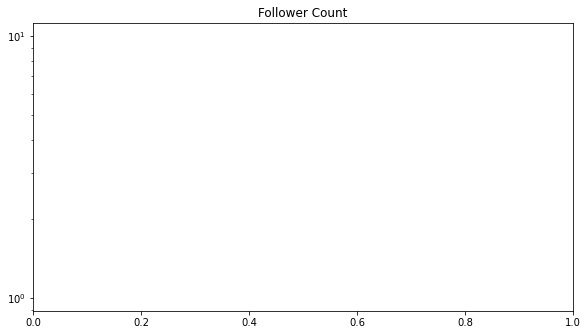

In [10]:
# Follower counts
followerCountFig = plt.figure()
axFollowers = followerCountFig.add_axes([0,0,1,1])
axFollowers.set_title("Follower Count")
axFollowers.set_yscale('log')

values = [rawUserData[index].followersCount for index in range(len(rawUserData))]
labels = []
for i in range(0, len(accounts)):
    labels.append(f"{accounts[i]}\n{values[i]}")

axFollowers.bar(labels, values)

# Following counts
followingCountFig = plt.figure()
axFollowing = followingCountFig.add_axes([0,0,1,1])
axFollowing.set_title("Following Count")
axFollowing.set_yscale('log')

values = [rawUserData[index].followingCount for index in range(len(rawUserData))]
labels = []
for i in range(0, len(accounts)):
    labels.append(f"{accounts[i]}\n{values[i]}")

axFollowing.bar(labels, values)

# Follower / Following Ratio
for i in range(len(rawUserData)):
    print(f"{accountNames[i]}- {rawUserData[i].followersCount} / {rawUserData[i].followingCount}: {(rawUserData[i].followersCount / rawUserData[i].followingCount)}")

# Function for plotting mention freuqnecies
def plotMentions(plot, userIndex):    
    plot.subplots_adjust(top=5, bottom=4.9)
    
    ax = plot.add_axes([0,0,1,1])
    ax.set_title(f"{accounts[userIndex]} Mention Count")

    analyser.setTarget(rawUserData[userIndex].userID)
    mentionCounts = analyser.getMentions().value_counts()
    index = 0
    for count in mentionCounts:
        if count == 1:
            break
        index+=1
    labels = mentionCounts.index[:index]
    values = mentionCounts[:index]

    ax.plot(labels, values)
    
    plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right', fontsize='large')
    
plotMentions(plt.figure(), 0)
plotMentions(plt.figure(), 1)
plotMentions(plt.figure(), 2)

# Function for plotting mention freuqnecies
def plotHashtags(plot, userIndex):    
    plot.subplots_adjust(top=5, bottom=4.9)
    
    ax = plot.add_axes([0,0,1,1])
    ax.set_title(f"{accounts[userIndex]} Hashtag Count")

    analyser.setTarget(rawUserData[userIndex].userID)
    hashtagCounts = analyser.getHashtags().value_counts()
    index = 0
    for count in hashtagCounts:
        if count == 1:
            if(index < 3):
                index = 10
            break
        index+=1
    labels = hashtagCounts.index[:index]
    values = hashtagCounts[:index]

    ax.plot(labels, values)
    
    plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right', fontsize='large')

plotHashtags(plt.figure(), 0)
plotHashtags(plt.figure(), 1)
plotHashtags(plt.figure(), 2)
    
# Values for tweet counts, and their retweet and favourite count
tweetValues = [rawUserData[index].tweetCount for index in range(len(rawUserData))]
retweetValues = []
favouriteValues = []
for userID in accountIDs.keys():
    analyser.setTarget(userID) # Set the analyser's target to the current loop iteration value
    retweetValues.append(analyser.getRetweets().explode().sum())
    favouriteValues.append(analyser.getFavourites().explode().sum())

# Tweet count
tweetCountFig = plt.figure()
axTweetCount = tweetCountFig.add_axes([0,0,1,1])
axTweetCount.set_title("Tweet Count")

labels = []
for i in range(0, len(accountNames)):
    labels.append(f"{accounts[i]}\n{tweetValues[i]}")
    
axTweetCount.bar(labels, tweetValues)

# Retweet count
retweetFig = plt.figure()
axRetweetCount = retweetFig.add_axes([0,0,1,1])
axRetweetCount.set_title("Retweet Count")
axRetweetCount.set_yscale("log")

labels = []
for i in range(0, len(accountNames)):
    labels.append(f"{accounts[i]}\n{retweetValues[i]}")
    
axRetweetCount.bar(labels, retweetValues)

# Favourite count
favouriteFig = plt.figure()
axFavouriteCount = favouriteFig.add_axes([0,0,1,1])
axFavouriteCount.set_title("Favourite Count")
axFavouriteCount.set_yscale("log")

labels = []
for i in range(0, len(accountNames)):
    labels.append(f"{accounts[i]}\n{favouriteValues[i]}")
    
axFavouriteCount.bar(labels, favouriteValues)

# Display plots
plt.show()

# Task 3 - Network Analysis

For a given account, it has a bidrectional network of influence. That is, account A can interact with account B, but account B can also interact with account A.

Using NetworkX and the pre-processed PandasUserData information, we will create and explore a network of each account.


In [15]:
import networkx as nx
from typing import List

class NetworkClass:
    def produceNetwork(oNetwork, lFollowingList, iInfluencerAccID):
        #Counter for the for loop
        iCount = 0
        #Go through each account ID in the list
        for oAccount in lFollowingList:
            #Produce only 10 nodes
            if iCount == 10:
                break
            #Add the account ID node
            oNetwork.add_node(oAccount)
            #Link the influencer account ID node to the associated account ID node
            oNetwork.add_edge(*(iInfluencerAccID, oAccount))
            iCount += 1
        return oNetwork
    
#Lists to store data from the Panda dataframe
lFollowingLists = [] #List will store 3 elements which each element will contain a following list for each account
lJFollowingAcc = [] #List will store the following list for iJustine
lBFollowingAcc = [] #List will store the following list for Barack Obama
lLFollowingAcc = [] #List will store the following list for Leonardo DiCaprio
lRetweetCounts = []

#Store all the account IDs for the 3 influencers
iJAccID = dataset.accountFrame.query('name == "iJustine"')['account_id'].iloc[0]
iBAccID = dataset.accountFrame.query('name == "Barack Obama"')['account_id'].iloc[0]
iLAccID = dataset.accountFrame.query('name == "Leonardo DiCaprio"')['account_id'].iloc[0]
#Check if the account IDs are stored
print("iJustine: " + str(iJAccID) + "\nBarack Obama: " + str(iBAccID) + "\nLeonardo DiCaprio:" + str(iLAccID) + "\n")

def extractFollowingLists():
    #Counter for the for loop
    iCount = 0
    #Extract all the following lists from the Panda dataframe
    lFollowingLists.append(dataset.accountFrame.query('name == "iJustine"')['friend_ids'].iloc[0])
    lFollowingLists.append(dataset.accountFrame.query('name == "Barack Obama"')['friend_ids'].iloc[0])
    lFollowingLists.append(dataset.accountFrame.query('name == "Leonardo DiCaprio"')['friend_ids'].iloc[0])

    print("Following Lists:")
    for lFollowingList in lFollowingLists:
        #Check if the following lists are stored
        print(str(lFollowingList) + "\n")

        #Append each account id to the relevant list
        for oAccount in lFollowingList:
            if iCount == 0:
                lJFollowingAcc.append(oAccount) #iJustine
            elif iCount == 1:
                lBFollowingAcc.append(oAccount) #Barack Obama
            elif iCount == 2:
                lLFollowingAcc.append(oAccount) #Leonardo DiCaprio

        iCount += 1

    #Check if the friend lists are stored
    print("\niJustine:\n" + str(lJFollowingAcc))
    print("\nBarack Obama:\n" + str(lBFollowingAcc))
    print("\nLeonardo DiCaprio:\n" + str(lLFollowingAcc))

def extractRetweets():
    print("hi")

def createNetwork():
    #Create a network graph
    oNetwork = nx.Graph()
    #Add 3 nodes for the influencers account IDs
    oNetwork.add_node(iJAccID)
    oNetwork = NetworkClass.produceNetwork(oNetwork, lJFollowingAcc, iJAccID)
    oNetwork.add_node(iBAccID)
    oNetwork = NetworkClass.produceNetwork(oNetwork, lBFollowingAcc, iBAccID)
    oNetwork.add_node(iLAccID)
    oNetwork = NetworkClass.produceNetwork(oNetwork, lLFollowingAcc, iLAccID)

extractFollowingLists()
#extractRetweets()
createNetwork()

iJustine: 7846
Barack Obama: 813286
Leonardo DiCaprio:133880286

Following Lists:
[2538267829, 1386694282996715522, 18007213, 820673148295192577, 3496641, 1090141, 834400338312564736, 1300495749478785026, 1413608544142721024, 14053116, 14661920, 50085192, 574032254, 59318218, 361384396, 3050707454, 1299965377355505666, 1573265498, 41777199, 1141757163045441536, 395514600, 41038781, 391037985, 23395456, 3289027731, 64931388, 134376725, 612076511, 544828911, 155768059, 18536658, 1118321164483473408, 308693201, 25694156, 490932793, 24871896, 168234688, 231534898, 300878069, 1102361186224336897, 1366471417181720578, 357267834, 2897431, 941091016731279361, 19202616, 898708204951031809, 17653553, 1076857425083408386, 281777578, 196066226, 1252051231331287049, 34442404, 956969150001197056, 146579141, 361871810, 1601374154, 48687278, 109058897, 732773, 16315757, 18530063, 19690116, 49573859, 831772091426930688, 18789373, 15101052, 16261861, 1064855894121476098, 22677790, 129330180, 10668202, 2